# Q-learning or Q-network (QN)

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [2]:
import numpy as np

In [3]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [4]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0') # 200 total reward as goal
env = gym.make('CartPole-v1') # 500 total reward as goal

/home/arasdar/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [5]:
# env.reset()
# batch = []
# for _ in range(1000):
#     # env.render()
#     action = env.action_space.sample()
#     state, reward, done, info = env.step(action) # take a random action
#     batch.append([action, state, reward, done, info])
#     #print('state, action, reward, done, info:', state, action, reward, done, info)
#     if done:
#         env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [6]:
# batch[0], batch[0][1].shape

In [7]:
# actions = np.array([each[0] for each in batch])
# states = np.array([each[1] for each in batch])
# rewards = np.array([each[2] for each in batch])
# dones = np.array([each[3] for each in batch])
# infos = np.array([each[4] for each in batch])

In [8]:
# print(rewards[-20:])
# print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
# print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
# print(np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
# print(np.max(np.array(rewards)), np.min(np.array(rewards)))
# print(np.max(np.array(states)), np.min(np.array(states)))

The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [9]:
def model_input(state_size):
    actions = tf.placeholder(tf.int32, [None], name='actions')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    return actions, states, targetQs

In [10]:
# Generator: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [11]:
def model_loss(actions, states, targetQs, # model input
               action_size, hidden_size): # model init
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs = tf.reduce_max(actions_logits*actions_labels, axis=1)
    loss = tf.reduce_mean(tf.square(Qs - targetQs))
    return actions_logits, loss

In [12]:
def model_opt(loss, learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)

    return opt

In [13]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.actions, self.states, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs) # model input

        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [14]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [17]:
# print('state size:{}'.format(states.shape), 
#       'actions:{}'.format(actions.shape)) 
# print('action size:', np.max(actions) - np.min(actions)+1)

In [18]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
action_size = 2
state_size = 4
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
gamma = 0.99                   # future reward discount

In [19]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [20]:
state = env.reset()
#for _ in range(batch_size):
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    state = next_state
    if done is True:
        state = env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [21]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list, loss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
    
    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0
        loss_batch = []
        state = env.reset()

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            total_reward += reward
            state = next_state

            # Training
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            next_states = np.array([each[2] for each in batch])
            rewards = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            next_actions_logits = sess.run(model.actions_logits, feed_dict = {model.states: next_states})
            nextQs = np.max(next_actions_logits, axis=1) * (1-dones)
            targetQs = rewards + (gamma * nextQs)
            loss, _ = sess.run([model.loss, model.opt], feed_dict = {model.states: states, 
                                                                     model.actions: actions,
                                                                     model.targetQs: targetQs})
            loss_batch.append(loss)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{}'.format(total_reward),
              'loss:{:.4f}'.format(np.mean(loss_batch)),
              'exploreP:{:.4f}'.format(explore_p))
        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        loss_list.append([ep, np.mean(loss_batch)])
        # Break episode/epoch loop
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model-qn.ckpt')

Episode:0 meanR:31.0000 R:31.0 loss:1.0898 exploreP:0.9969
Episode:1 meanR:26.0000 R:21.0 loss:1.2221 exploreP:0.9949
Episode:2 meanR:25.0000 R:23.0 loss:1.3412 exploreP:0.9926
Episode:3 meanR:23.5000 R:19.0 loss:1.5201 exploreP:0.9907
Episode:4 meanR:22.4000 R:18.0 loss:1.5324 exploreP:0.9890
Episode:5 meanR:26.1667 R:45.0 loss:1.7430 exploreP:0.9846
Episode:6 meanR:24.5714 R:15.0 loss:2.0085 exploreP:0.9831
Episode:7 meanR:23.2500 R:14.0 loss:1.9773 exploreP:0.9818
Episode:8 meanR:25.6667 R:45.0 loss:1.9378 exploreP:0.9774
Episode:9 meanR:24.9000 R:18.0 loss:1.7361 exploreP:0.9757
Episode:10 meanR:23.8182 R:13.0 loss:1.6080 exploreP:0.9744
Episode:11 meanR:25.3333 R:42.0 loss:1.6871 exploreP:0.9704
Episode:12 meanR:26.0000 R:34.0 loss:1.7071 exploreP:0.9671
Episode:13 meanR:25.7143 R:22.0 loss:1.6988 exploreP:0.9650
Episode:14 meanR:26.0667 R:31.0 loss:1.8533 exploreP:0.9620
Episode:15 meanR:25.4375 R:16.0 loss:1.9495 exploreP:0.9605
Episode:16 meanR:24.6471 R:12.0 loss:2.1821 explor

Episode:137 meanR:19.5700 R:17.0 loss:34.3171 exploreP:0.7561
Episode:138 meanR:19.6500 R:23.0 loss:47.5168 exploreP:0.7543
Episode:139 meanR:19.7200 R:19.0 loss:33.9093 exploreP:0.7529
Episode:140 meanR:19.7100 R:13.0 loss:32.9857 exploreP:0.7520
Episode:141 meanR:19.5100 R:21.0 loss:30.6911 exploreP:0.7504
Episode:142 meanR:19.5900 R:20.0 loss:25.9793 exploreP:0.7489
Episode:143 meanR:19.4900 R:9.0 loss:31.1370 exploreP:0.7483
Episode:144 meanR:19.5400 R:17.0 loss:18.6827 exploreP:0.7470
Episode:145 meanR:19.6300 R:19.0 loss:38.6110 exploreP:0.7456
Episode:146 meanR:19.6700 R:18.0 loss:28.4316 exploreP:0.7443
Episode:147 meanR:19.4800 R:13.0 loss:14.3737 exploreP:0.7433
Episode:148 meanR:19.6800 R:37.0 loss:32.3340 exploreP:0.7406
Episode:149 meanR:19.7700 R:25.0 loss:35.7258 exploreP:0.7388
Episode:150 meanR:19.7400 R:15.0 loss:20.9522 exploreP:0.7377
Episode:151 meanR:19.6800 R:12.0 loss:25.6219 exploreP:0.7368
Episode:152 meanR:19.6900 R:12.0 loss:40.1611 exploreP:0.7360
Episode:1

Episode:271 meanR:39.5900 R:66.0 loss:16.2834 exploreP:0.4822
Episode:272 meanR:40.3500 R:89.0 loss:22.9524 exploreP:0.4780
Episode:273 meanR:40.5700 R:41.0 loss:23.9723 exploreP:0.4761
Episode:274 meanR:41.1500 R:85.0 loss:19.4067 exploreP:0.4721
Episode:275 meanR:41.4900 R:48.0 loss:26.6917 exploreP:0.4699
Episode:276 meanR:42.1100 R:72.0 loss:19.6169 exploreP:0.4666
Episode:277 meanR:42.4500 R:45.0 loss:24.3930 exploreP:0.4645
Episode:278 meanR:42.3800 R:16.0 loss:25.5589 exploreP:0.4638
Episode:279 meanR:42.9500 R:68.0 loss:18.9638 exploreP:0.4607
Episode:280 meanR:43.3500 R:49.0 loss:22.8213 exploreP:0.4585
Episode:281 meanR:45.2300 R:208.0 loss:21.9329 exploreP:0.4493
Episode:282 meanR:45.8400 R:72.0 loss:22.4343 exploreP:0.4462
Episode:283 meanR:46.0300 R:43.0 loss:36.2461 exploreP:0.4443
Episode:284 meanR:46.4700 R:58.0 loss:26.1716 exploreP:0.4418
Episode:285 meanR:47.3200 R:100.0 loss:25.8566 exploreP:0.4375
Episode:286 meanR:47.7200 R:50.0 loss:21.8974 exploreP:0.4353
Episod

Episode:402 meanR:209.0800 R:500.0 loss:16.1297 exploreP:0.0575
Episode:403 meanR:213.6600 R:500.0 loss:21.1197 exploreP:0.0551
Episode:404 meanR:217.5500 R:500.0 loss:17.6929 exploreP:0.0529
Episode:405 meanR:222.2000 R:500.0 loss:19.2104 exploreP:0.0508
Episode:406 meanR:226.3200 R:500.0 loss:14.9434 exploreP:0.0489
Episode:407 meanR:230.6200 R:500.0 loss:11.1374 exploreP:0.0470
Episode:408 meanR:234.9300 R:500.0 loss:17.1882 exploreP:0.0452
Episode:409 meanR:238.9800 R:500.0 loss:17.1683 exploreP:0.0434
Episode:410 meanR:243.3500 R:500.0 loss:12.9414 exploreP:0.0418
Episode:411 meanR:247.8700 R:500.0 loss:15.5234 exploreP:0.0403
Episode:412 meanR:252.3600 R:500.0 loss:14.9694 exploreP:0.0388
Episode:413 meanR:256.5800 R:500.0 loss:17.7346 exploreP:0.0374
Episode:414 meanR:260.7000 R:500.0 loss:14.6895 exploreP:0.0360
Episode:415 meanR:264.5700 R:500.0 loss:17.9299 exploreP:0.0348
Episode:416 meanR:266.7500 R:328.0 loss:13.5866 exploreP:0.0340
Episode:417 meanR:267.7500 R:182.0 loss:

Episode:531 meanR:120.7800 R:25.0 loss:66.7512 exploreP:0.0135
Episode:532 meanR:116.1700 R:39.0 loss:70.8998 exploreP:0.0135
Episode:533 meanR:111.5700 R:40.0 loss:172.9506 exploreP:0.0135
Episode:534 meanR:107.6100 R:104.0 loss:180.3463 exploreP:0.0134
Episode:535 meanR:104.9700 R:236.0 loss:86.7927 exploreP:0.0134
Episode:536 meanR:103.1900 R:322.0 loss:95.2555 exploreP:0.0132
Episode:537 meanR:100.8600 R:267.0 loss:72.1389 exploreP:0.0132
Episode:538 meanR:102.4600 R:359.0 loss:72.9178 exploreP:0.0130
Episode:539 meanR:106.4000 R:482.0 loss:65.7513 exploreP:0.0129
Episode:540 meanR:110.2500 R:500.0 loss:54.6133 exploreP:0.0128
Episode:541 meanR:114.4700 R:500.0 loss:38.4813 exploreP:0.0126
Episode:542 meanR:118.7700 R:500.0 loss:39.6145 exploreP:0.0125
Episode:543 meanR:123.1300 R:454.0 loss:52.0369 exploreP:0.0124
Episode:544 meanR:125.1900 R:225.0 loss:61.7514 exploreP:0.0123
Episode:545 meanR:126.8500 R:185.0 loss:77.1679 exploreP:0.0123
Episode:546 meanR:127.8800 R:124.0 loss:8

Episode:661 meanR:146.5900 R:500.0 loss:4.8129 exploreP:0.0105
Episode:662 meanR:151.5000 R:500.0 loss:3.7941 exploreP:0.0105
Episode:663 meanR:155.6500 R:424.0 loss:6.0569 exploreP:0.0105
Episode:664 meanR:160.5600 R:500.0 loss:6.5121 exploreP:0.0104
Episode:665 meanR:165.4700 R:500.0 loss:12.8393 exploreP:0.0104
Episode:666 meanR:170.3800 R:500.0 loss:9.4491 exploreP:0.0104
Episode:667 meanR:175.2800 R:500.0 loss:16.5135 exploreP:0.0104
Episode:668 meanR:180.1800 R:500.0 loss:6.4095 exploreP:0.0104
Episode:669 meanR:185.0800 R:500.0 loss:13.3130 exploreP:0.0103
Episode:670 meanR:189.9900 R:500.0 loss:11.3754 exploreP:0.0103
Episode:671 meanR:194.9100 R:500.0 loss:18.8069 exploreP:0.0103
Episode:672 meanR:199.8200 R:500.0 loss:9.9733 exploreP:0.0103
Episode:673 meanR:204.3000 R:456.0 loss:16.8830 exploreP:0.0103
Episode:674 meanR:208.1700 R:399.0 loss:20.7469 exploreP:0.0103
Episode:675 meanR:213.0700 R:500.0 loss:14.0734 exploreP:0.0103
Episode:676 meanR:217.9800 R:500.0 loss:10.3627

Episode:791 meanR:312.7600 R:239.0 loss:0.5062 exploreP:0.0100
Episode:792 meanR:312.0300 R:251.0 loss:0.7818 exploreP:0.0100
Episode:793 meanR:311.1700 R:233.0 loss:0.6783 exploreP:0.0100
Episode:794 meanR:309.9900 R:230.0 loss:0.4716 exploreP:0.0100
Episode:795 meanR:308.9400 R:246.0 loss:0.5092 exploreP:0.0100
Episode:796 meanR:309.0400 R:262.0 loss:0.6322 exploreP:0.0100
Episode:797 meanR:307.7700 R:231.0 loss:0.5818 exploreP:0.0100
Episode:798 meanR:306.8200 R:260.0 loss:0.4723 exploreP:0.0100
Episode:799 meanR:305.7300 R:241.0 loss:0.5501 exploreP:0.0100
Episode:800 meanR:304.6900 R:240.0 loss:0.5325 exploreP:0.0100
Episode:801 meanR:303.7800 R:250.0 loss:0.5324 exploreP:0.0100
Episode:802 meanR:303.1300 R:271.0 loss:0.4378 exploreP:0.0100
Episode:803 meanR:302.6800 R:236.0 loss:0.4908 exploreP:0.0100
Episode:804 meanR:302.3500 R:252.0 loss:0.5110 exploreP:0.0100
Episode:805 meanR:301.3900 R:262.0 loss:0.5166 exploreP:0.0100
Episode:806 meanR:300.2700 R:228.0 loss:0.5482 exploreP

Episode:922 meanR:260.5400 R:359.0 loss:0.4591 exploreP:0.0100
Episode:923 meanR:262.4200 R:436.0 loss:0.6749 exploreP:0.0100
Episode:924 meanR:264.3500 R:444.0 loss:0.5433 exploreP:0.0100
Episode:925 meanR:266.7500 R:473.0 loss:0.5553 exploreP:0.0100
Episode:926 meanR:268.8000 R:466.0 loss:0.6774 exploreP:0.0100
Episode:927 meanR:269.2900 R:288.0 loss:0.8254 exploreP:0.0100
Episode:928 meanR:272.0000 R:500.0 loss:0.7959 exploreP:0.0100
Episode:929 meanR:274.4600 R:500.0 loss:1.0795 exploreP:0.0100
Episode:930 meanR:277.1800 R:496.0 loss:1.4827 exploreP:0.0100
Episode:931 meanR:279.8700 R:500.0 loss:1.2193 exploreP:0.0100
Episode:932 meanR:282.5800 R:500.0 loss:2.2392 exploreP:0.0100
Episode:933 meanR:285.1100 R:500.0 loss:1.8608 exploreP:0.0100
Episode:934 meanR:287.2000 R:448.0 loss:1.0490 exploreP:0.0100
Episode:935 meanR:289.6700 R:500.0 loss:3.5203 exploreP:0.0100
Episode:936 meanR:291.3100 R:404.0 loss:2.0092 exploreP:0.0100
Episode:937 meanR:292.1700 R:335.0 loss:6.9801 exploreP

Episode:1051 meanR:317.5200 R:500.0 loss:25.9374 exploreP:0.0100
Episode:1052 meanR:317.6900 R:500.0 loss:37.3377 exploreP:0.0100
Episode:1053 meanR:317.8300 R:500.0 loss:40.2696 exploreP:0.0100
Episode:1054 meanR:317.8300 R:500.0 loss:24.9981 exploreP:0.0100
Episode:1055 meanR:317.8300 R:500.0 loss:30.4384 exploreP:0.0100
Episode:1056 meanR:317.8300 R:500.0 loss:12.5817 exploreP:0.0100
Episode:1057 meanR:318.4000 R:500.0 loss:15.9221 exploreP:0.0100
Episode:1058 meanR:318.4000 R:500.0 loss:13.0182 exploreP:0.0100
Episode:1059 meanR:318.4000 R:500.0 loss:19.4173 exploreP:0.0100
Episode:1060 meanR:318.4000 R:500.0 loss:13.7967 exploreP:0.0100
Episode:1061 meanR:318.2400 R:484.0 loss:15.7017 exploreP:0.0100
Episode:1062 meanR:317.5600 R:432.0 loss:8.3818 exploreP:0.0100
Episode:1063 meanR:321.9600 R:500.0 loss:14.4977 exploreP:0.0100
Episode:1064 meanR:326.6600 R:495.0 loss:8.1802 exploreP:0.0100
Episode:1065 meanR:330.5700 R:411.0 loss:10.9770 exploreP:0.0100
Episode:1066 meanR:335.3800

Episode:1179 meanR:483.4600 R:461.0 loss:8.1779 exploreP:0.0100
Episode:1180 meanR:484.1700 R:500.0 loss:4.7185 exploreP:0.0100
Episode:1181 meanR:484.5900 R:500.0 loss:6.7547 exploreP:0.0100
Episode:1182 meanR:484.5900 R:500.0 loss:10.3321 exploreP:0.0100
Episode:1183 meanR:485.3200 R:500.0 loss:7.8283 exploreP:0.0100
Episode:1184 meanR:485.3200 R:500.0 loss:8.5257 exploreP:0.0100
Episode:1185 meanR:485.3200 R:500.0 loss:8.5484 exploreP:0.0100
Episode:1186 meanR:485.3200 R:500.0 loss:10.0985 exploreP:0.0100
Episode:1187 meanR:486.1800 R:500.0 loss:8.0276 exploreP:0.0100
Episode:1188 meanR:486.1800 R:500.0 loss:7.1289 exploreP:0.0100
Episode:1189 meanR:487.1900 R:500.0 loss:10.2684 exploreP:0.0100
Episode:1190 meanR:487.1900 R:500.0 loss:10.9602 exploreP:0.0100
Episode:1191 meanR:487.8300 R:500.0 loss:9.0041 exploreP:0.0100
Episode:1192 meanR:488.4500 R:500.0 loss:6.0167 exploreP:0.0100
Episode:1193 meanR:488.4500 R:500.0 loss:7.2112 exploreP:0.0100
Episode:1194 meanR:488.5100 R:388.0 

Episode:1307 meanR:383.9800 R:500.0 loss:3.6707 exploreP:0.0100
Episode:1308 meanR:383.9800 R:500.0 loss:5.1847 exploreP:0.0100
Episode:1309 meanR:385.3500 R:447.0 loss:7.4029 exploreP:0.0100
Episode:1310 meanR:386.6500 R:500.0 loss:4.6004 exploreP:0.0100
Episode:1311 meanR:384.9900 R:330.0 loss:4.7038 exploreP:0.0100
Episode:1312 meanR:385.0600 R:321.0 loss:8.4632 exploreP:0.0100
Episode:1313 meanR:387.4400 R:500.0 loss:4.2141 exploreP:0.0100
Episode:1314 meanR:389.5600 R:500.0 loss:7.4695 exploreP:0.0100
Episode:1315 meanR:391.3700 R:500.0 loss:9.9049 exploreP:0.0100
Episode:1316 meanR:390.9400 R:350.0 loss:8.1171 exploreP:0.0100
Episode:1317 meanR:390.8400 R:374.0 loss:4.6302 exploreP:0.0100
Episode:1318 meanR:390.8300 R:324.0 loss:3.4956 exploreP:0.0100
Episode:1319 meanR:391.0700 R:325.0 loss:4.3629 exploreP:0.0100
Episode:1320 meanR:393.3400 R:500.0 loss:4.0073 exploreP:0.0100
Episode:1321 meanR:394.2500 R:500.0 loss:6.1813 exploreP:0.0100
Episode:1322 meanR:395.6500 R:476.0 loss

Episode:1435 meanR:228.3300 R:389.0 loss:6.5722 exploreP:0.0100
Episode:1436 meanR:232.6700 R:443.0 loss:5.8664 exploreP:0.0100
Episode:1437 meanR:237.2600 R:468.0 loss:3.6589 exploreP:0.0100
Episode:1438 meanR:242.0300 R:486.0 loss:3.0819 exploreP:0.0100
Episode:1439 meanR:245.8000 R:387.0 loss:3.9879 exploreP:0.0100
Episode:1440 meanR:249.5800 R:387.0 loss:3.1046 exploreP:0.0100
Episode:1441 meanR:254.4800 R:500.0 loss:3.8175 exploreP:0.0100
Episode:1442 meanR:258.6400 R:426.0 loss:6.4828 exploreP:0.0100
Episode:1443 meanR:263.0400 R:449.0 loss:3.3997 exploreP:0.0100
Episode:1444 meanR:267.0000 R:405.0 loss:4.2628 exploreP:0.0100
Episode:1445 meanR:271.3600 R:444.0 loss:2.9914 exploreP:0.0100
Episode:1446 meanR:275.3800 R:412.0 loss:2.1797 exploreP:0.0100
Episode:1447 meanR:279.5600 R:427.0 loss:3.3612 exploreP:0.0100
Episode:1448 meanR:284.2000 R:474.0 loss:2.6022 exploreP:0.0100
Episode:1449 meanR:288.2700 R:418.0 loss:3.8228 exploreP:0.0100
Episode:1450 meanR:292.2400 R:408.0 loss

Episode:1567 meanR:81.1500 R:11.0 loss:495.7131 exploreP:0.0100
Episode:1568 meanR:76.2700 R:12.0 loss:15.5738 exploreP:0.0100
Episode:1569 meanR:71.3600 R:9.0 loss:4366.5278 exploreP:0.0100
Episode:1570 meanR:66.4500 R:9.0 loss:765.2240 exploreP:0.0100
Episode:1571 meanR:61.5500 R:10.0 loss:554.9197 exploreP:0.0100
Episode:1572 meanR:56.6400 R:9.0 loss:2259.2417 exploreP:0.0100
Episode:1573 meanR:51.7500 R:11.0 loss:1420.0389 exploreP:0.0100
Episode:1574 meanR:46.8400 R:9.0 loss:26.9836 exploreP:0.0100
Episode:1575 meanR:41.9200 R:8.0 loss:308.1771 exploreP:0.0100
Episode:1576 meanR:37.0200 R:10.0 loss:297.1762 exploreP:0.0100
Episode:1577 meanR:32.1500 R:13.0 loss:27.8427 exploreP:0.0100
Episode:1578 meanR:27.2400 R:9.0 loss:2039.9709 exploreP:0.0100
Episode:1579 meanR:22.3500 R:11.0 loss:1407.2620 exploreP:0.0100
Episode:1580 meanR:17.4400 R:9.0 loss:560.4407 exploreP:0.0100
Episode:1581 meanR:14.4300 R:9.0 loss:3772.2283 exploreP:0.0100
Episode:1582 meanR:14.4200 R:9.0 loss:857.322

Episode:1695 meanR:104.9000 R:9.0 loss:2226.1377 exploreP:0.0100
Episode:1696 meanR:104.9100 R:10.0 loss:239.7721 exploreP:0.0100
Episode:1697 meanR:104.9100 R:9.0 loss:224.3389 exploreP:0.0100
Episode:1698 meanR:104.9200 R:11.0 loss:2611.4861 exploreP:0.0100
Episode:1699 meanR:104.9000 R:8.0 loss:242.4133 exploreP:0.0100
Episode:1700 meanR:104.9200 R:10.0 loss:251.5226 exploreP:0.0100
Episode:1701 meanR:104.9100 R:8.0 loss:2637.4966 exploreP:0.0100
Episode:1702 meanR:104.9200 R:9.0 loss:2988.5120 exploreP:0.0100
Episode:1703 meanR:104.8900 R:9.0 loss:276.2797 exploreP:0.0100
Episode:1704 meanR:104.8900 R:10.0 loss:1689.9705 exploreP:0.0100
Episode:1705 meanR:104.8900 R:9.0 loss:256.4890 exploreP:0.0100
Episode:1706 meanR:104.8700 R:9.0 loss:733.2044 exploreP:0.0100
Episode:1707 meanR:104.8800 R:11.0 loss:3219.2734 exploreP:0.0100
Episode:1708 meanR:104.8800 R:9.0 loss:3614.3782 exploreP:0.0100
Episode:1709 meanR:104.8800 R:10.0 loss:4511.5239 exploreP:0.0100
Episode:1710 meanR:104.900

Episode:1822 meanR:38.2100 R:171.0 loss:450.9421 exploreP:0.0100
Episode:1823 meanR:40.1000 R:200.0 loss:301.8312 exploreP:0.0100
Episode:1824 meanR:41.8800 R:188.0 loss:396.7692 exploreP:0.0100
Episode:1825 meanR:43.5500 R:176.0 loss:352.2964 exploreP:0.0100
Episode:1826 meanR:45.4300 R:197.0 loss:312.9314 exploreP:0.0100
Episode:1827 meanR:47.2800 R:196.0 loss:264.8248 exploreP:0.0100
Episode:1828 meanR:49.3800 R:222.0 loss:236.7958 exploreP:0.0100
Episode:1829 meanR:51.6300 R:236.0 loss:216.3621 exploreP:0.0100
Episode:1830 meanR:53.9300 R:242.0 loss:189.0959 exploreP:0.0100
Episode:1831 meanR:55.8100 R:207.0 loss:182.8285 exploreP:0.0100
Episode:1832 meanR:57.1000 R:245.0 loss:145.6632 exploreP:0.0100
Episode:1833 meanR:60.0400 R:500.0 loss:152.9577 exploreP:0.0100
Episode:1834 meanR:61.8300 R:295.0 loss:142.3963 exploreP:0.0100
Episode:1835 meanR:64.2400 R:286.0 loss:136.9646 exploreP:0.0100
Episode:1836 meanR:68.9100 R:500.0 loss:120.4960 exploreP:0.0100
Episode:1837 meanR:73.560

Episode:1948 meanR:454.5000 R:500.0 loss:10.7856 exploreP:0.0100
Episode:1949 meanR:457.9600 R:500.0 loss:8.5243 exploreP:0.0100
Episode:1950 meanR:460.9700 R:500.0 loss:9.2865 exploreP:0.0100
Episode:1951 meanR:464.2900 R:500.0 loss:8.8618 exploreP:0.0100
Episode:1952 meanR:467.7700 R:500.0 loss:7.5640 exploreP:0.0100
Episode:1953 meanR:471.0900 R:500.0 loss:10.5947 exploreP:0.0100
Episode:1954 meanR:474.0300 R:500.0 loss:10.9954 exploreP:0.0100
Episode:1955 meanR:477.3400 R:500.0 loss:7.8821 exploreP:0.0100
Episode:1956 meanR:480.1400 R:500.0 loss:8.4654 exploreP:0.0100
Episode:1957 meanR:480.1400 R:500.0 loss:8.2131 exploreP:0.0100
Episode:1958 meanR:483.3000 R:500.0 loss:11.0224 exploreP:0.0100
Episode:1959 meanR:486.5400 R:500.0 loss:7.6436 exploreP:0.0100
Episode:1960 meanR:489.0600 R:500.0 loss:6.9155 exploreP:0.0100
Episode:1961 meanR:491.1600 R:500.0 loss:8.3986 exploreP:0.0100
Episode:1962 meanR:491.1600 R:500.0 loss:8.0270 exploreP:0.0100
Episode:1963 meanR:491.1600 R:500.0 

Episode:2077 meanR:21.4400 R:292.0 loss:106.1425 exploreP:0.0100
Episode:2078 meanR:24.1300 R:279.0 loss:173.5516 exploreP:0.0100
Episode:2079 meanR:28.1300 R:410.0 loss:220.0318 exploreP:0.0100
Episode:2080 meanR:29.6400 R:161.0 loss:297.3782 exploreP:0.0100
Episode:2081 meanR:30.6800 R:113.0 loss:219.5672 exploreP:0.0100
Episode:2082 meanR:35.5800 R:500.0 loss:353.2868 exploreP:0.0100
Episode:2083 meanR:40.4900 R:500.0 loss:329.5272 exploreP:0.0100
Episode:2084 meanR:41.9100 R:151.0 loss:365.9873 exploreP:0.0100
Episode:2085 meanR:46.8200 R:500.0 loss:315.6017 exploreP:0.0100
Episode:2086 meanR:51.7100 R:500.0 loss:285.3721 exploreP:0.0100
Episode:2087 meanR:56.6000 R:500.0 loss:252.0508 exploreP:0.0100
Episode:2088 meanR:61.4800 R:500.0 loss:188.5849 exploreP:0.0100
Episode:2089 meanR:64.9900 R:361.0 loss:185.7281 exploreP:0.0100
Episode:2090 meanR:68.7800 R:389.0 loss:133.6645 exploreP:0.0100
Episode:2091 meanR:73.6700 R:500.0 loss:151.5177 exploreP:0.0100
Episode:2092 meanR:77.440

Episode:2205 meanR:365.0100 R:473.0 loss:0.3632 exploreP:0.0100
Episode:2206 meanR:365.3400 R:419.0 loss:0.4139 exploreP:0.0100
Episode:2207 meanR:365.0800 R:418.0 loss:0.2300 exploreP:0.0100
Episode:2208 meanR:364.7200 R:433.0 loss:0.2492 exploreP:0.0100
Episode:2209 meanR:364.9900 R:454.0 loss:0.2140 exploreP:0.0100
Episode:2210 meanR:365.6400 R:432.0 loss:0.3002 exploreP:0.0100
Episode:2211 meanR:366.0700 R:434.0 loss:0.2769 exploreP:0.0100
Episode:2212 meanR:367.1400 R:440.0 loss:0.3520 exploreP:0.0100
Episode:2213 meanR:368.5600 R:480.0 loss:0.2298 exploreP:0.0100
Episode:2214 meanR:370.1500 R:459.0 loss:0.5026 exploreP:0.0100
Episode:2215 meanR:371.9000 R:461.0 loss:0.2411 exploreP:0.0100
Episode:2216 meanR:373.8000 R:487.0 loss:0.3588 exploreP:0.0100
Episode:2217 meanR:375.7500 R:500.0 loss:0.3132 exploreP:0.0100
Episode:2218 meanR:376.9000 R:437.0 loss:0.3690 exploreP:0.0100
Episode:2219 meanR:379.1200 R:498.0 loss:0.3841 exploreP:0.0100
Episode:2220 meanR:381.0200 R:500.0 loss

Episode:2334 meanR:148.2000 R:65.0 loss:144.1415 exploreP:0.0100
Episode:2335 meanR:143.9300 R:73.0 loss:136.7226 exploreP:0.0100
Episode:2336 meanR:139.6400 R:71.0 loss:193.1948 exploreP:0.0100
Episode:2337 meanR:135.4400 R:58.0 loss:226.8203 exploreP:0.0100
Episode:2338 meanR:131.1100 R:67.0 loss:263.2415 exploreP:0.0100
Episode:2339 meanR:126.7800 R:67.0 loss:308.1509 exploreP:0.0100
Episode:2340 meanR:122.3500 R:57.0 loss:242.8435 exploreP:0.0100
Episode:2341 meanR:118.0200 R:59.0 loss:244.9050 exploreP:0.0100
Episode:2342 meanR:113.7800 R:57.0 loss:229.7510 exploreP:0.0100
Episode:2343 meanR:109.4500 R:67.0 loss:295.4641 exploreP:0.0100
Episode:2344 meanR:105.0900 R:64.0 loss:342.5070 exploreP:0.0100
Episode:2345 meanR:100.7200 R:63.0 loss:288.8796 exploreP:0.0100
Episode:2346 meanR:96.5000 R:78.0 loss:493.6669 exploreP:0.0100
Episode:2347 meanR:92.5100 R:71.0 loss:348.3962 exploreP:0.0100
Episode:2348 meanR:88.2300 R:72.0 loss:500.5876 exploreP:0.0100
Episode:2349 meanR:83.9400 R

Episode:2462 meanR:203.3100 R:11.0 loss:25.4266 exploreP:0.0100
Episode:2463 meanR:204.3900 R:200.0 loss:625.9620 exploreP:0.0100
Episode:2464 meanR:207.1300 R:379.0 loss:352.9519 exploreP:0.0100
Episode:2465 meanR:206.1200 R:9.0 loss:767.3345 exploreP:0.0100
Episode:2466 meanR:205.2700 R:9.0 loss:331.9545 exploreP:0.0100
Episode:2467 meanR:204.1700 R:8.0 loss:254.7788 exploreP:0.0100
Episode:2468 meanR:202.4300 R:8.0 loss:770.5677 exploreP:0.0100
Episode:2469 meanR:199.3900 R:9.0 loss:521.4207 exploreP:0.0100
Episode:2470 meanR:195.0600 R:9.0 loss:297.8993 exploreP:0.0100
Episode:2471 meanR:190.1600 R:10.0 loss:688.4968 exploreP:0.0100
Episode:2472 meanR:185.8300 R:9.0 loss:410.4642 exploreP:0.0100
Episode:2473 meanR:181.9000 R:9.0 loss:256.8510 exploreP:0.0100
Episode:2474 meanR:177.5900 R:10.0 loss:298.7293 exploreP:0.0100
Episode:2475 meanR:175.4500 R:9.0 loss:829.1417 exploreP:0.0100
Episode:2476 meanR:173.6600 R:10.0 loss:2183.7522 exploreP:0.0100
Episode:2477 meanR:171.4500 R:8.

Episode:2588 meanR:140.7900 R:320.0 loss:369.0218 exploreP:0.0100
Episode:2589 meanR:144.1800 R:348.0 loss:311.9361 exploreP:0.0100
Episode:2590 meanR:146.9200 R:284.0 loss:269.7363 exploreP:0.0100
Episode:2591 meanR:150.0900 R:327.0 loss:303.6126 exploreP:0.0100
Episode:2592 meanR:154.9900 R:500.0 loss:390.8860 exploreP:0.0100
Episode:2593 meanR:159.9000 R:500.0 loss:381.0547 exploreP:0.0100
Episode:2594 meanR:164.8200 R:500.0 loss:295.7666 exploreP:0.0100
Episode:2595 meanR:169.7300 R:500.0 loss:182.4722 exploreP:0.0100
Episode:2596 meanR:173.6100 R:398.0 loss:136.9850 exploreP:0.0100
Episode:2597 meanR:178.5300 R:500.0 loss:108.9941 exploreP:0.0100
Episode:2598 meanR:183.4300 R:500.0 loss:74.3349 exploreP:0.0100
Episode:2599 meanR:187.4000 R:407.0 loss:65.2532 exploreP:0.0100
Episode:2600 meanR:192.1200 R:480.0 loss:62.7935 exploreP:0.0100
Episode:2601 meanR:197.0200 R:500.0 loss:33.5247 exploreP:0.0100
Episode:2602 meanR:201.9300 R:500.0 loss:9.1636 exploreP:0.0100
Episode:2603 mea

Episode:2715 meanR:450.6400 R:248.0 loss:32.4216 exploreP:0.0100
Episode:2716 meanR:450.6400 R:500.0 loss:46.4720 exploreP:0.0100
Episode:2717 meanR:450.6400 R:500.0 loss:45.5159 exploreP:0.0100
Episode:2718 meanR:450.6400 R:500.0 loss:29.7500 exploreP:0.0100
Episode:2719 meanR:450.6400 R:500.0 loss:21.8573 exploreP:0.0100
Episode:2720 meanR:450.6400 R:500.0 loss:47.1768 exploreP:0.0100
Episode:2721 meanR:450.6400 R:500.0 loss:34.5141 exploreP:0.0100
Episode:2722 meanR:450.6400 R:500.0 loss:25.7070 exploreP:0.0100
Episode:2723 meanR:450.6400 R:500.0 loss:30.4949 exploreP:0.0100
Episode:2724 meanR:450.6400 R:500.0 loss:16.5319 exploreP:0.0100
Episode:2725 meanR:450.6400 R:500.0 loss:16.2809 exploreP:0.0100
Episode:2726 meanR:450.6400 R:500.0 loss:24.4436 exploreP:0.0100
Episode:2727 meanR:450.6400 R:500.0 loss:29.5999 exploreP:0.0100
Episode:2728 meanR:447.4500 R:181.0 loss:5.1028 exploreP:0.0100
Episode:2729 meanR:443.7400 R:129.0 loss:88.3451 exploreP:0.0100
Episode:2730 meanR:439.920

Episode:2842 meanR:118.4700 R:100.0 loss:374.0473 exploreP:0.0100
Episode:2843 meanR:119.3800 R:101.0 loss:370.1376 exploreP:0.0100
Episode:2844 meanR:120.2500 R:97.0 loss:1241.6543 exploreP:0.0100
Episode:2845 meanR:121.0800 R:93.0 loss:1708.4883 exploreP:0.0100
Episode:2846 meanR:121.3100 R:32.0 loss:1306.8883 exploreP:0.0100
Episode:2847 meanR:121.4400 R:23.0 loss:770.8937 exploreP:0.0100
Episode:2848 meanR:122.2400 R:88.0 loss:879.5555 exploreP:0.0100
Episode:2849 meanR:122.9200 R:77.0 loss:2116.6121 exploreP:0.0100
Episode:2850 meanR:123.0200 R:20.0 loss:1711.8782 exploreP:0.0100
Episode:2851 meanR:123.0900 R:17.0 loss:1275.8500 exploreP:0.0100
Episode:2852 meanR:123.2300 R:23.0 loss:2836.1509 exploreP:0.0100
Episode:2853 meanR:123.3300 R:20.0 loss:1388.2952 exploreP:0.0100
Episode:2854 meanR:123.4100 R:18.0 loss:1832.1615 exploreP:0.0100
Episode:2855 meanR:123.5300 R:20.0 loss:2514.1492 exploreP:0.0100
Episode:2856 meanR:123.6300 R:20.0 loss:957.1545 exploreP:0.0100
Episode:2857 

Episode:2967 meanR:307.5500 R:500.0 loss:14.4493 exploreP:0.0100
Episode:2968 meanR:312.3900 R:500.0 loss:13.3159 exploreP:0.0100
Episode:2969 meanR:317.2300 R:500.0 loss:14.4836 exploreP:0.0100
Episode:2970 meanR:322.0800 R:500.0 loss:16.8953 exploreP:0.0100
Episode:2971 meanR:326.8800 R:500.0 loss:16.7468 exploreP:0.0100
Episode:2972 meanR:331.6000 R:500.0 loss:13.6453 exploreP:0.0100
Episode:2973 meanR:336.3500 R:500.0 loss:12.2768 exploreP:0.0100
Episode:2974 meanR:341.0900 R:500.0 loss:14.7159 exploreP:0.0100
Episode:2975 meanR:345.8400 R:500.0 loss:10.1816 exploreP:0.0100
Episode:2976 meanR:350.6500 R:500.0 loss:17.6303 exploreP:0.0100
Episode:2977 meanR:355.4200 R:500.0 loss:12.1091 exploreP:0.0100
Episode:2978 meanR:360.1900 R:500.0 loss:14.5655 exploreP:0.0100
Episode:2979 meanR:364.9300 R:500.0 loss:13.2814 exploreP:0.0100
Episode:2980 meanR:369.6100 R:500.0 loss:18.2362 exploreP:0.0100
Episode:2981 meanR:374.1600 R:500.0 loss:10.3591 exploreP:0.0100
Episode:2982 meanR:378.61

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

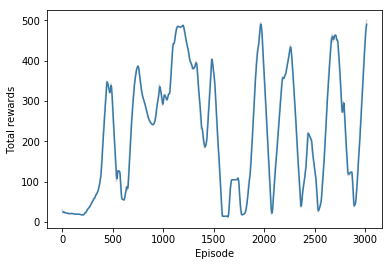

In [24]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

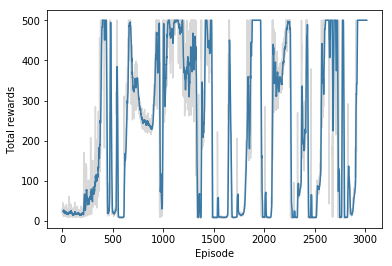

In [25]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

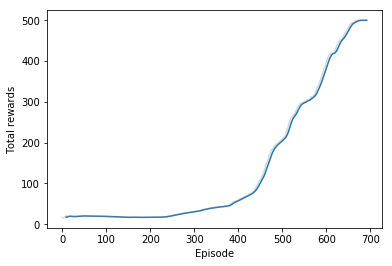

In [20]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

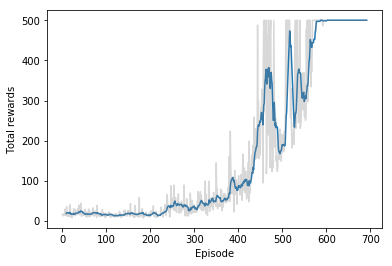

In [21]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Average losses')

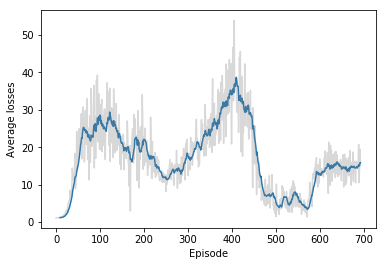

In [22]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

Text(0,0.5,'Total rewards')

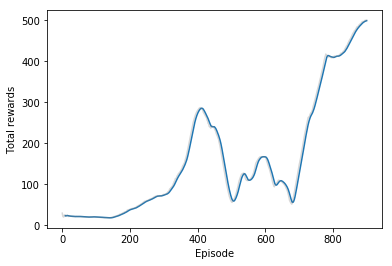

In [42]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

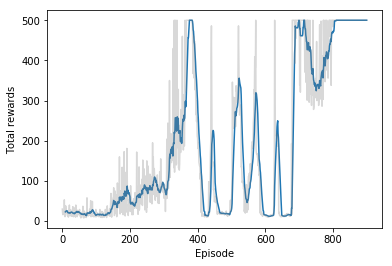

In [43]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Average losses')

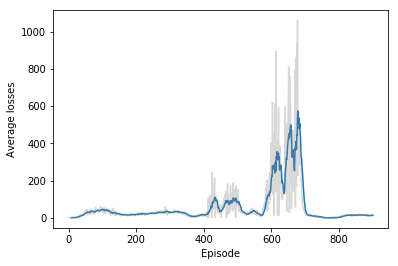

In [44]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

## Testing

Let's checkout how our trained agent plays the game.

In [23]:
# Creating a gym env
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

# A training graph session
with tf.Session(graph=graph) as sess:
    #sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model-qn.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
                
        # Closing the env
        print('total_reward: {}'.format(total_reward))
# Close the env at the end
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model-qn.ckpt


/home/arasdar/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.